## Info

This is a testing notebook for the Huber Robust Elastic Net built in Python based on the following:

- https://rdrr.io/cran/hqreg/man/hqreg.html
- https://arxiv.org/abs/1509.02957

It uses the Boston Data Set from sklearn as test data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma

import os
import gc

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

### Import Data and Elastic Net

In [2]:
from fnbbase.models import HuberElasticNet

import sklearn.datasets

In [3]:
boston = sklearn.datasets.load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['target'])

In [4]:
X.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33

In [5]:
y.head()

target
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2

### Scale the Data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
ss = StandardScaler()
xs = pd.DataFrame(ss.fit_transform(X), columns=X.columns)
ys = ss.fit_transform(y)

In [8]:
alpha = 1.0
depth = 99

In [9]:
model = HuberElasticNet.HuberRegressor(alpha=alpha, depth=depth, tol=1e-12, scale=None, center=None)
model.fit(xs, y.values.reshape(-1,1))
yhat = model.predict()

## sklearn pipeline test
pipe = Pipeline([('stdscaler', StandardScaler()), 
                 ('huber', model)])
pipe.fit(xs, y.values.reshape(-1,1))
yhat_pipe = pipe.predict(xs)

model_from_pipe = pipe.named_steps.huber

### outliers

In [10]:
outliers = y*model.outliers

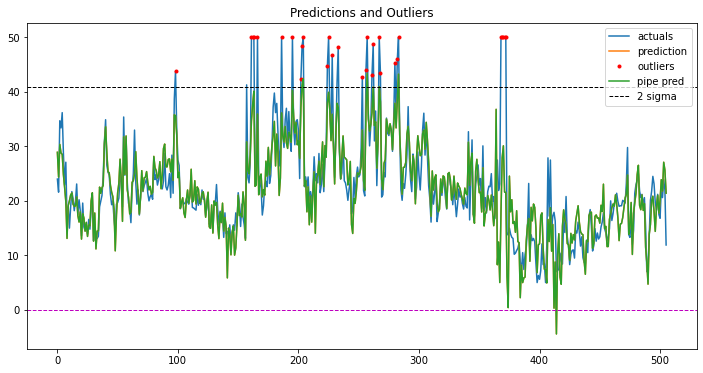

In [11]:
yoc = y.mean()+2*y.std()
fig, ax=plt.subplots(1,1,figsize=(12,6))
y.plot(ax=ax);
ax.plot(yhat);
ax.plot(outliers[outliers > 0], 'ro', ms=3);
ax.plot(yhat_pipe);# , ls=':', color='g', lw=1);
ax.axhline(yoc[0], ls='--', color='k', lw=1);
ax.axhline(0, ls='--', color='m', lw=1);
ax.legend(['actuals','prediction','outliers','pipe pred','2 sigma']);
plt.title("Predictions and Outliers");

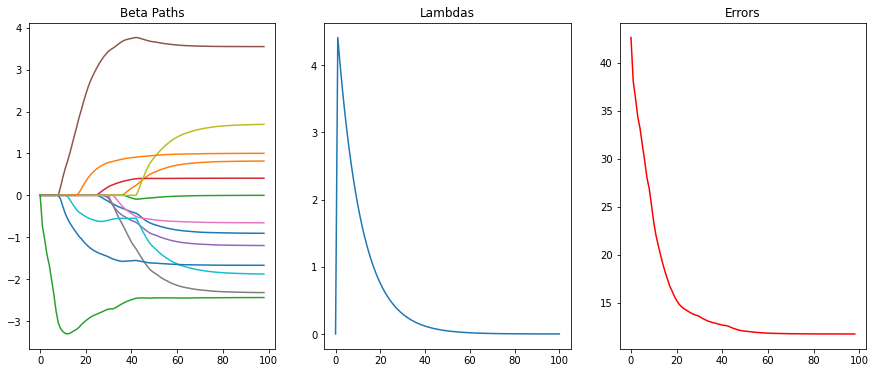

In [12]:
fig, ax=plt.subplots(1,3,figsize=(15,6))
ax[0].plot(model.B.T); ax[0].set_title("Beta Paths")
ax[1].plot(model.lambdas); ax[1].set_title("Lambdas")
ax[2].plot(model.model_errors, color='r'); ax[2].set_title("Errors");


### Statsmodels Comparison


In [13]:
rlm = sma.RLM(exog=sma.add_constant(xs), endog=y)
rfit = rlm.fit() #cov='H3')

my_model = pd.DataFrame(np.append(model.B0[:,-1], model.B[:,-1], 0), index=['const']+list(X.columns))
param_compare = pd.concat([my_model, rfit.params.to_frame()], axis=1)
param_compare.columns = ['my_model','statsmodels']
param_compare['abs diff'] = np.fabs(param_compare.statsmodels - param_compare.my_model)
param_compare

my_model  statsmodels  abs diff
const    21.930438    21.930048  0.000390
CRIM     -0.906290    -0.909373  0.003082
ZN        0.817563     0.820175  0.002612
INDUS    -0.000861    -0.000244  0.000618
CHAS      0.408371     0.408450  0.000079
NOX      -1.198138    -1.200188  0.002050
RM        3.549079     3.548875  0.000204
AGE      -0.655686    -0.657213  0.001528
DIS      -2.321376    -2.325931  0.004555
RAD       1.693565     1.702408  0.008843
TAX      -1.877916    -1.884751  0.006835
PTRATIO  -1.669732    -1.670029  0.000297
B         1.002344     1.003666  0.001322
LSTAT    -2.439738    -2.438299  0.001439

**It would be nice to get closer precision but these are two different solvers.**

In [14]:
print(rfit.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 target   No. Observations:                  506
Model:                            RLM   Df Residuals:                      492
Method:                          IRLS   Df Model:                           13
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 19 Jan 2021                                         
Time:                        08:25:38                                         
No. Iterations:                    30                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9300      0.155    141.712      0.0

In [15]:
print(np.linalg.norm(param_compare['abs diff'],2))

0.013153325458530875


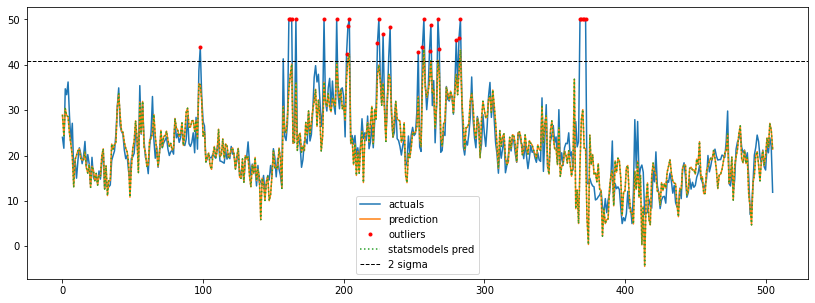

In [16]:
rpred = rfit.predict()
fig, ax=plt.subplots(1,1,figsize=(14,5))
y.plot(ax=ax);
ax.plot(yhat_pipe);
ax.plot(outliers[outliers > 0], 'ro', ms=3);
ax.plot(rpred, ls=':');
ax.axhline(yoc[0], ls='--', color='k', lw=1);
ax.legend(['actuals','prediction','outliers','statsmodels pred','2 sigma']);

## Example with FNB Time Series CrossValidation

In [17]:
from fnbbase.models import CrossValidation, ElasticNetUtils

In [18]:
n_splits = 5
test_size = 10

## specify the model
model = HuberElasticNet.HuberRegressor(alpha=alpha, depth=depth, tol=1e-12, scale=None, center=None)
## specify the FNB time series split for CV
tss = CrossValidation.FNBTimeSeriesSplit(n_splits=n_splits, test_size=test_size)    
## call the cross validator
crossval = CrossValidation.CrossValidator(model, tss)
## fit
crossval.fit(xs, y.values.reshape(-1,1))

**You have to call cv_data_agg() from the crossval method to aggregate all the info.**

In [19]:
results = crossval.cv_data_agg()

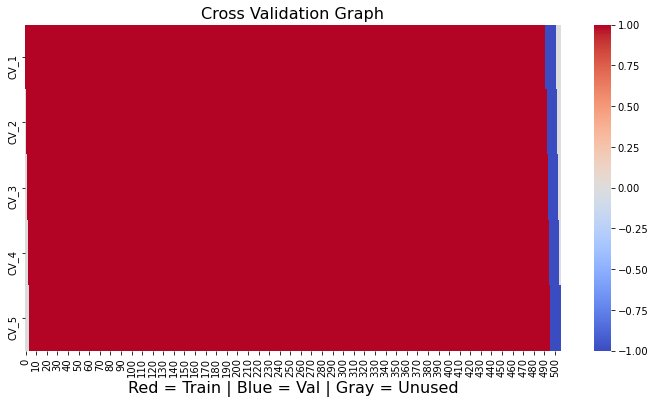

In [32]:
graph = ElasticNetUtils.cv_graph(xs, n_splits, test_size, plot=False); ## only works for our time series

fig, ax=plt.subplots(1,1,figsize=(12,6))
sns.heatmap(graph.T, ax=ax, cmap='coolwarm', vmin=-1, vmax=1);
ax.set_title("Cross Validation Graph", fontsize=16);
ax.set_xlabel("Red = Train | Blue = Val | Gray = Unused", fontsize=16);

**there are a lot of points in this so we only see a few per each hold out at the end**

In [21]:
bcf, mean_coefs = crossval.coefficient_frequency()
bcf

variable value_sign  count   percent  cumulative_count  cumulative_percent
0       TAX        neg      5  8.928571                 5            8.928571
1        RM        pos      5  8.928571                10           17.857143
2   PTRATIO        neg      5  8.928571                15           26.785714
3     LSTAT        neg      5  8.928571                20           35.714286
4       DIS        neg      5  8.928571                25           44.642857
5      CRIM        neg      5  8.928571                30           53.571429
6      CHAS        pos      5  8.928571                35           62.500000
7         B        pos      5  8.928571                40           71.428571
8        ZN        pos      4  7.142857                44           78.571429
9       NOX        neg      4  7.142857                48           85.714286
10      AGE        neg      4  7.142857                52           92.857143
11      RAD        pos      2  3.571429                54           96.428571
12    INDUS        pos      2  3.571429                56          100.000000

This shows that many of the variables are found in all 5 of the CVs. Where as INDUS was only found in two.

**Please remember that this is a TIME SERIES SPECIFIC validator and not a K-FOLD validator which may be more appropriate here.**

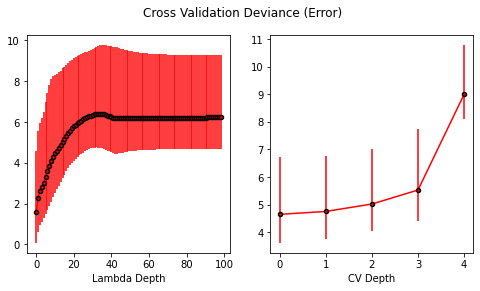

In [22]:
ElasticNetUtils.err_plot(crossval.mod_err, figsize=(8,4))

The error plots show:
- For the lambda depth plot, each black dot represents the error at each lambda depth and the red error bars represent the variance over each cross validation at that depth.

- For the CV depth plot, each black dot represents the error at each CV and the red error bars represent the variance over each lambda at that depth.

In the fit methods of the CVs and models there is a quick variable finding and setting the minimum error of that fit and those variables are chosen there and the values are set. In the charts above these get defined as showing our minimum error across the lambdas was at 0 (sparse model) and at the first CV.

In [23]:
crossval.mindices

[98, 98, 39, 38, 29]

If you call *crossval.mindices* it returns the maximum index of the lowest lamba error indices over the cross validation. This corresponds to the smallest error with the most amount of variables per cross validation.